In [2]:
import numpy as np
import bilby 
import matplotlib.pyplot as plot
import scipy
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plot
import tov
from tov import tov
from tov import eos
from tov import tov_utils
from tov import tov_utils_new
import tov.constants as u
from collections import namedtuple
import functools
from functools import partial
from tov import *
import pickle
import pandas as pd
import pickle
import bayestack_main 

Maximum relative correction: (n, E, P) = (1.7998267614230648e-05, 1.7992924306987604e-05, 2.5341856980737207e-09)


In [24]:
##SFHx data
df = pd.read_csv(r"C:\Users\Abhimkul\Downloads\SFHx)_Data_points")
energy = df.iloc[:,0].to_numpy()
Pressure = df.iloc[:,1].to_numpy()
df

,energy,Pressure
0,146.502707,0.991250
1,149.272780,1.101501
2,152.677989,1.192164
3,154.982229,1.301679
4,157.917191,1.421254
...,...,...
102,2543.137455,1336.454564
103,2640.941972,1396.491086
104,2752.896728,1459.224583
105,2837.273092,1511.434437


Text(0.5, 1.0, 'SFHx EoS')

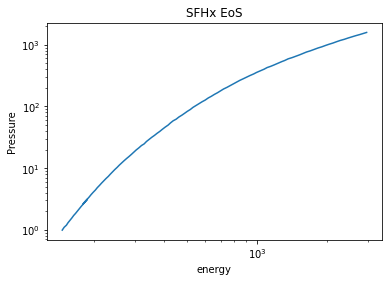

In [5]:
##Plotting 
plot.plot(energy,Pressure)
plot.xscale("log")
plot.yscale("log")
plot.xlabel("energy")
plot.ylabel("Pressure")
plot.title("SFHx EoS")

Text(0.5, 1.0, 'SFHX 7PP fit')

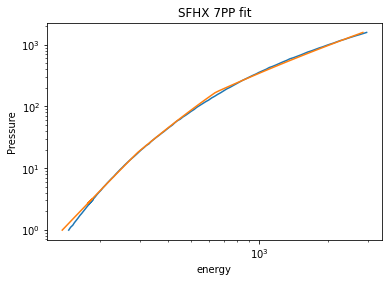

In [6]:
## 7 PP fit
Params = namedtuple('EoSReadCoreParams', ['log_p1', 'G1', 'G2', 'G3'])
EoS_fit = eos.EoS_Read(params = Params(34.45666095,  3.9087,  3.257,  2.1105))
energy_fit = np.array([EoS_fit.E_P(_p) for _p in Pressure])
plot.plot(energy,Pressure)
plot.plot(energy_fit, Pressure)
plot.xscale("log")
plot.yscale("log")
plot.xlabel("energy")
plot.ylabel("Pressure")
plot.title("SFHX 7PP fit")

In [7]:
##Solving TOV equation for 7PP fit eos

solve = tov_utils.TOV_Solver(eos_object= EoS_fit)
M,R = solve.tsolve(pct= 47.6099/1000 , scode = "odeint")
M1,R1 = solve.tsolve(pct= 66.11/1000 , scode = "odeint")
M2,R2 = solve.tsolve(pct= 93.1/1000 , scode = "odeint")
M3,R3 = solve.tsolve(pct= 132.51/1000 , scode = "odeint")
print("M:",M,"R:",R,"km")
print("M:",M1,"R:",R1,"km")
print("M:",M2,"R:",R2,"km")
print("M:",M3,"R:",R3,"km")

M: 1.201005738816446 R: 11.90144190964875 km
M: 1.4014819191934593 R: 11.970347656741795 km
M: 1.6077927630503939 R: 11.985201176852406 km
M: 1.8067812767605895 R: 11.931594252722046 km


In [27]:
#prior
my_prior = dict(
    GA1=bilby.core.prior.Uniform(2, 4.5, name='GA1', latex_label = r"$\Gamma_1$"),
    GA2=bilby.core.prior.Uniform(1.5, 8, name='GA2', latex_label = r"$\Gamma_2$"),
    GA3=bilby.core.prior.Uniform(1.5, 8, name='GA3', latex_label = r"$\Gamma_3$"),
    log_p1=bilby.core.prior.Uniform(34.3, 34.9, name='log_p1')
)

# Likelihood 
class My_likelihood(bilby.Likelihood):

    def __init__(self, data1, data2, data3, data4):
        super().__init__(parameters={"GA1": None, "GA2": None, "GA3": None, "log_p1": None})
        self.data1 = data1
        self.data2 = data2
        self.data3 = data3
        self.data4 = data4

    def log_likelihood(self):
        # Extract parameters from self.parameters
        GA1 = self.parameters["GA1"]
        GA2 = self.parameters["GA2"]
        GA3 = self.parameters["GA3"]
        log_p1 = self.parameters["log_p1"]

        
        # Solving TOV for the prior EoS 
        try: 
            Params = namedtuple('EoSReadCoreParams', ['logp1', 'G1', 'G2', 'G3'])
            EoS_ = eos.EoS_Read(params=Params(logp1=log_p1, G1=GA1, G2=GA2, G3=GA3))
            solve = tov_utils.TOV_Solver(eos_object=EoS_)

            #using the Pc to calculate R1.X
            A = tov_utils_new.TOV_Solver(eos_object = EoS_)
            Pc_12, a, b = A.get_Pc_M(M = 1.2) 
            Pc_14, a1, b1 = A.get_Pc_M(M = 1.4)
            Pc_16, a2, b2 = A.get_Pc_M(M = 1.6)
            Pc_18, a2, b2 = A.get_Pc_M(M = 1.8)

            #TOV Solve
            M_12, R_12 = solve.tsolve(pct=Pc_12[0]/1000, scode="odeint")
            M_14, R_14 = solve.tsolve(pct=Pc_14[0]/1000, scode="odeint")
            M_16, R_16 = solve.tsolve(pct=Pc_16[0]/1000, scode="odeint")
            M_18, R_18 = solve.tsolve(pct=Pc_18[0]/1000, scode="odeint")
                
            # Data
            kde_12 = self.data1
            kde_14 = self.data2
            kde_16 = self.data3
            kde_18 = self.data4

            R = np.linspace(8, 16, 15000)

            f12 =scipy.interpolate.interp1d(R, kde_12, fill_value="extrapolate")
            f14 = scipy.interpolate.interp1d(R, kde_14, fill_value="extrapolate")
            f16 = scipy.interpolate.interp1d(R, kde_16, fill_value="extrapolate")
            f18 = scipy.interpolate.interp1d(R, kde_18, fill_value="extrapolate")

                
            log_likelihood_12 = (np.log(f12(R_12)))
            log_likelihood_14 = (np.log(f14(R_14)))
            log_likelihood_16 = (np.log(f16(R_16)))
            log_likelihood_18 = (np.log(f18(R_18)))
            
            total_log_likelihood = log_likelihood_12 + log_likelihood_14 + log_likelihood_16 + log_likelihood_18

            return total_log_likelihood
        
        except  (ValueError,ZeroDivisionError):
            return -np.inf   ##Probability will be zero at that eroor (EoS Parameters)

# Load data
df12 = np.loadtxt(r"C:\Users\Abhimkul\Downloads\kde12.txt")
df14 = np.loadtxt(r"C:\Users\Abhimkul\Downloads\kde14.txt")
df16 = np.loadtxt(r"C:\Users\Abhimkul\Downloads\kde16.txt")
df18 = np.loadtxt(r"C:\Users\Abhimkul\Downloads\kde18.txt")

data1 = df12[:, 1]
data2 = df14[:, 1]
data3 = df16[:, 1]
data4 = df18[:, 1]

#Final Likelihood
likelihood1 = My_likelihood(data1, data2, data3, data4)

In [28]:
# Run the sampler
result = bilby.run_sampler(
    likelihood=likelihood1,
    priors=my_prior,
    sampler="dynesty",
    nlive = 1000,
    label='Bayesian inference on EoS Parameters',
    outdir='outdir',
    verbose = True)

15:52 bilby INFO    : Running for label 'Bayesian inference on EoS Parameters', output will be saved to 'outdir'
15:52 bilby INFO    : Analysis priors:
15:52 bilby INFO    : GA1=Uniform(minimum=2, maximum=4.5, name='GA1', latex_label='$\\Gamma_1$', unit=None, boundary=None)
15:52 bilby INFO    : GA2=Uniform(minimum=1.5, maximum=8, name='GA2', latex_label='$\\Gamma_2$', unit=None, boundary=None)
15:52 bilby INFO    : GA3=Uniform(minimum=1.5, maximum=8, name='GA3', latex_label='$\\Gamma_3$', unit=None, boundary=None)
15:52 bilby INFO    : log_p1=Uniform(minimum=34.3, maximum=34.9, name='log_p1', latex_label='log_p1', unit=None, boundary=None)
15:52 bilby INFO    : Analysis likelihood class: <class '__main__.My_likelihood'>
15:52 bilby INFO    : Analysis likelihood noise evidence: nan


KeyboardInterrupt: 

In [20]:
mass= []
radius  = []
for i in Pc:
    solve1 = tov_utils.TOV_Solver(eos_object=EoS_fit)
    M,R  = solve1.tsolve(pct=i/1000, scode="odeint")
    mass.append(M)
    radius.append(R)

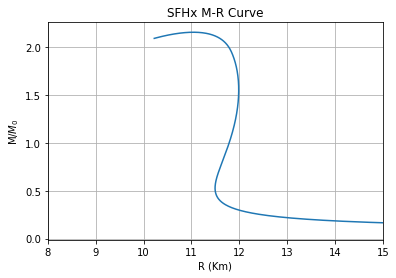

In [41]:
plot.plot(radius,mass)
plot.xlim(8,15)
plot.xlabel("R (Km)")
plot.ylabel("M/$M_0$")
plot.title("SFHx M-R Curve")
plot.grid()
# plot.ylim(0,50)

Text(0, 0.5, 'Pressure')

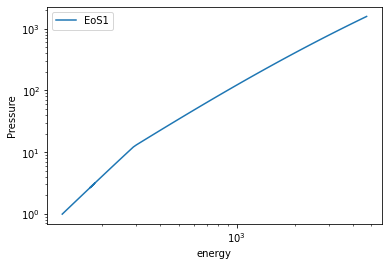

In [5]:
Params = namedtuple('EoSReadCoreParams', ['log_p1', 'G1', 'G2', 'G3'])
EoS_fit1 = eos.EoS_Read(params = Params(34.3,3,2,2))
energy1 = [EoS_fit1.E_P(P=i) for i in Pressure]
plot.plot(energy1,Pressure,label="EoS1")
#plot.plot(energy2,Pressure,label ="EoS2")
plot.legend()
plot.xscale("log")
plot.yscale("log")
plot.xlabel("energy")
plot.ylabel("Pressure")
